# Shape

> Shape generation and utilities

In [ ]:
# | default_exp shape

In [ ]:
# | export

import random

import numpy as np
from neuralresonator.modal import MATERIALS, System
from skfem import MeshTri
from skimage.draw import polygon2mask

In [ ]:
# | hide

import matplotlib.pyplot as plt

In [ ]:
# | export

def generate_convex_shape(n: int) -> np.ndarray:
    """
    This function was taken and adapted from https://stackoverflow.com/a/68602707

    Generate convex shappes according to Pavel Valtr's 1995 alogrithm. Ported from
    Sander Verdonschot's Java version, found here:
    https://cglab.ca/~sander/misc/ConvexGeneration/ValtrAlgorithm.java

    returns a numpy array of shape (n, 2)
    """

    # initialise random coordinates
    X_rand, Y_rand = np.sort(np.random.random(n)), np.sort(np.random.random(n))
    X_new, Y_new = np.zeros(n), np.zeros(n)

    # divide the interior points into two chains
    last_true = last_false = 0
    for i in range(1, n):
        if i != n - 1:
            if random.getrandbits(1):
                X_new[i] = X_rand[i] - X_rand[last_true]
                Y_new[i] = Y_rand[i] - Y_rand[last_true]
                last_true = i
            else:
                X_new[i] = X_rand[last_false] - X_rand[i]
                Y_new[i] = Y_rand[last_false] - Y_rand[i]
                last_false = i
        else:
            X_new[0] = X_rand[i] - X_rand[last_true]
            Y_new[0] = Y_rand[i] - Y_rand[last_true]
            X_new[i] = X_rand[last_false] - X_rand[i]
            Y_new[i] = Y_rand[last_false] - Y_rand[i]

    # randomly combine x and y and sort by polar angle
    np.random.shuffle(Y_new)
    vertices = np.stack((X_new, Y_new), axis=-1)
    vertices = vertices[np.argsort(np.arctan2(vertices[:, 1], vertices[:, 0]))]

    # arrange points end to end to form a polygon
    vertices = np.cumsum(vertices, axis=0)

    # center around the origin
    x_max, y_max = np.max(vertices[:, 0]), np.max(vertices[:, 1])
    vertices[:, 0] += ((x_max - np.min(vertices[:, 0])) / 2) - x_max
    vertices[:, 1] += ((y_max - np.min(vertices[:, 1])) / 2) - y_max

    return vertices


def generate_convex_mesh(
    n_points: int = 10, # number of points in the convex shape
    n_refinement_steps: int = 3, # number of refinement steps
) -> tuple[MeshTri, np.ndarray]: # mesh and points in the normalized range [-1.0, 1.0]
    
    """
    Generate a 2D convex mesh
    """
    import triangle

    # convex mesh generates a mesh normalized to [-0.5, 0.5]
    points = generate_convex_shape(n_points) * 2
    tri = triangle.triangulate({"vertices": points}, "q")
    return (
        MeshTri(tri["vertices"].T, tri["triangles"].T).refined(n_refinement_steps),
        points,
    )


In [ ]:
def rasterize(
    side: int,  # side of the image
    points: np.ndarray,  # points defining the shape
) -> np.ndarray:  # rasterized shape as a boolean array
    """
    Rasterize a shape defined by a set of points
    """
    return polygon2mask((side, side), ((points + 1.0) / 2.0) * side).T


Generate random convex polygons and rasterize them.

Text(0, 0.5, 'pixels y')

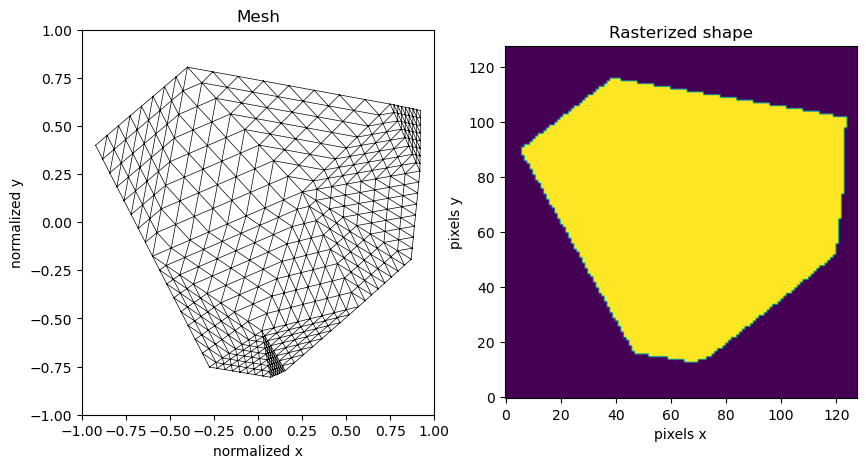

In [ ]:
mesh, points = generate_convex_mesh(10, 3)

system = System(MATERIALS['polycarbonate'], mesh)
eigenvalues = system.eigenvalues
eigenvectors = system.get_mode_gains()


fig, ax = plt.subplots(1, 2, figsize=(10, 5))


MeshTri.draw(mesh, shading={"wireframe": True}, ax=ax[0])
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
ax[0].set_title("Mesh")
ax[0].set_xlabel("normalized x")
ax[0].set_ylabel("normalized y")

mask = rasterize(128, points)
ax[1].imshow(mask, origin="lower")
ax[1].set_title("Rasterized shape")
ax[1].set_xlabel("pixels x")
ax[1].set_ylabel("pixels y")
